<a href="https://colab.research.google.com/github/miguel-escribano/AI_Solutions_Architecture/blob/main/4_Regression_Diabetes.V.3%3Afinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Regression Analysis on Diabetes Dataset**


**Objective**
- Compare the performance of Linear Regression, XGBoost, and Decision Trees on the scikit-learn diabetes dataset to predict disease progression.
- Document findings with insights and recommendations.


**What's Expected**


*   **Problem Definition**: Clearly define the regression problem and dataset.
*   **Linear Regression**: Implement and evaluate a linear regression model.
*   **XGBoost**: Implement and tune an XGBoost model.
*   **Decision Trees**: Implement and tune a decision tree model.
*   **Performance Comparison**: Compare models using RMSE, R2, and MAE.
*   **Documentation**: Summarize findings with insights and recommendations.

**Dataset Selection**

*   **Dataset**: scikit-learn `load_diabetes` dataset.
*   **Rationale**: The dataset contains 442 samples with 10 numeric features (e.g., age, BMI, blood pressure) and a continuous target variable representing diabetes progression after one year. It is ideal for regression analysis to explore how features predict disease severity.
*   **Regression Problem**: Predict the continuous target (disease progression) using features like age, BMI, and blood pressure.
*   **Source**: [scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html)
*   **Dataset Source**: Efron et al. (2004), 'Least Angle Regression,' Annals of Statistics, https://web.stanford.edu/~hastie/Papers/LARS/LeastAngle_2002.pdf

In [3]:
## 1. Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

In [4]:
## 2. Loading Data
# Load the diabetes dataset
diabetes = load_diabetes(as_frame=True)
X = diabetes.data
y = diabetes.target

# Combine features and target into a single DataFrame for EDA
df = pd.concat([X, y], axis=1)

Dataset Shape: (442, 11)

Feature Descriptions:
                age           sex           bmi            bp            s1  \
count  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02   
mean  -2.511817e-19  1.230790e-17 -2.245564e-16 -4.797570e-17 -1.381499e-17   
std    4.761905e-02  4.761905e-02  4.761905e-02  4.761905e-02  4.761905e-02   
min   -1.072256e-01 -4.464164e-02 -9.027530e-02 -1.123988e-01 -1.267807e-01   
25%   -3.729927e-02 -4.464164e-02 -3.422907e-02 -3.665608e-02 -3.424784e-02   
50%    5.383060e-03 -4.464164e-02 -7.283766e-03 -5.670422e-03 -4.320866e-03   
75%    3.807591e-02  5.068012e-02  3.124802e-02  3.564379e-02  2.835801e-02   
max    1.107267e-01  5.068012e-02  1.705552e-01  1.320436e-01  1.539137e-01   

                 s2            s3            s4            s5            s6  \
count  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02   
mean   3.918434e-17 -5.777179e-18 -9.042540e-18  9.293722e-17  1.130318e-17   
std

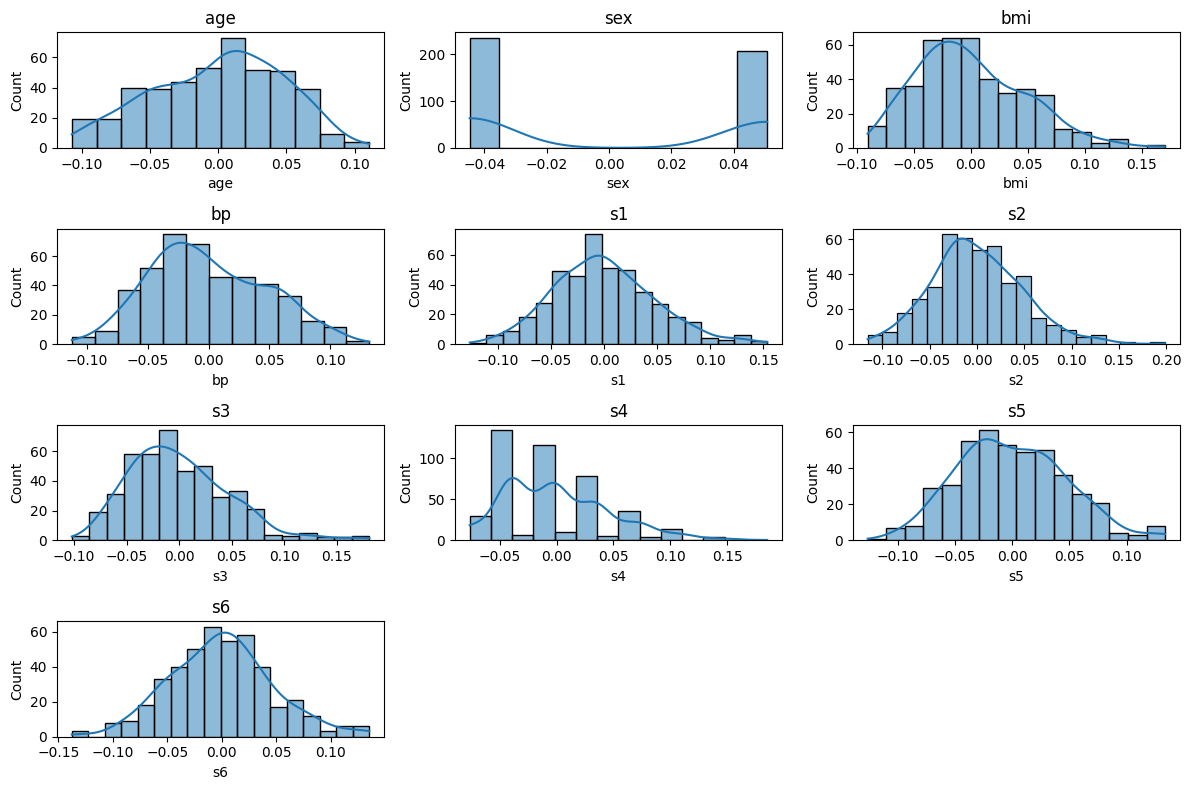

In [5]:
## 3. Data Analysis
### 3.1 Exploratory Data Analysis (EDA)
# Display basic information
print("Dataset Shape:", df.shape)
print("\nFeature Descriptions:")
print(df.describe())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Visualize feature distributions
plt.figure(figsize=(12, 8))
for i, col in enumerate(X.columns, 1):
    plt.subplot(4, 3, i)
    sns.histplot(X[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

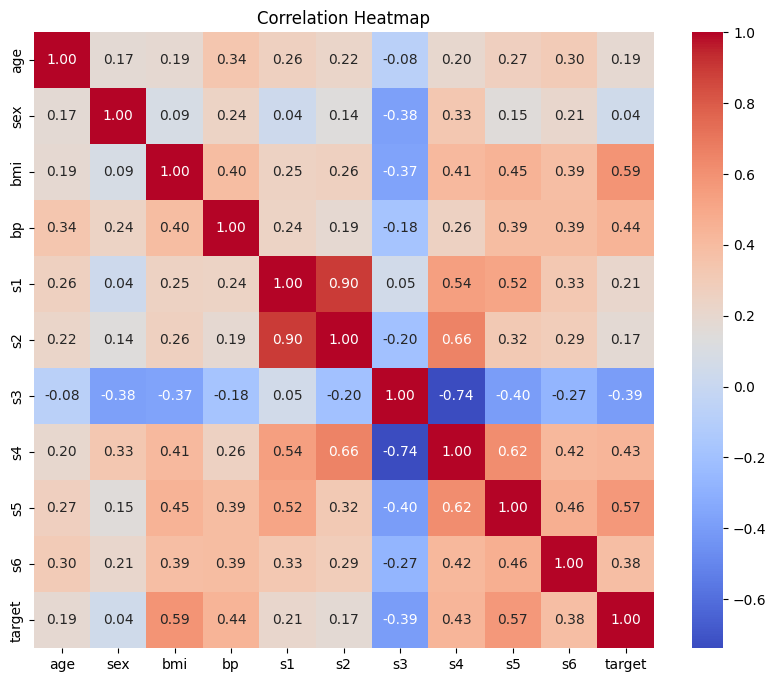

In [6]:
### 3.2 Feature Correlations
# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

Strong positive correlation between 'bmi' and 'target' (around 0.59), and between 's5' and 'target' (around 0.57). This suggests that these features are more strongly related to diabetes progression compared to others like 'sex' or 'age'.

In [7]:
## 4. Data Preprocessing
### 4.1 Data Cleaning
# No missing values in this dataset, but verify
if df.isnull().sum().sum() == 0:
    print("No missing values found.")

### 4.2 Feature Engineering and Scaling
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features (important for Linear Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

No missing values found.


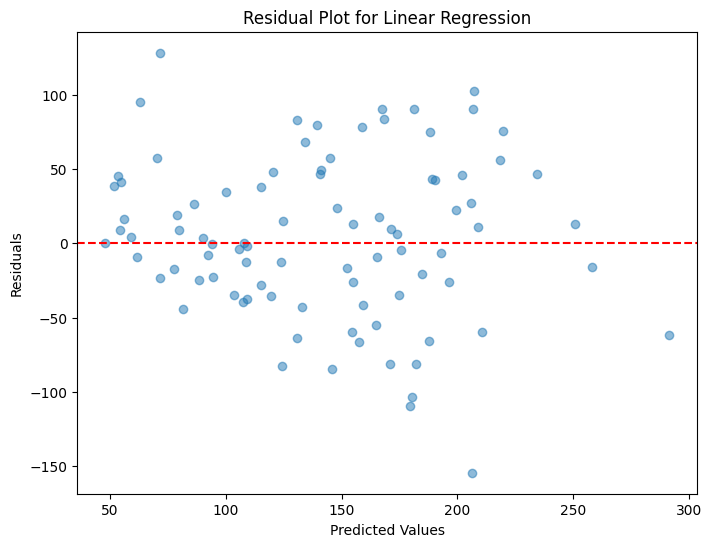

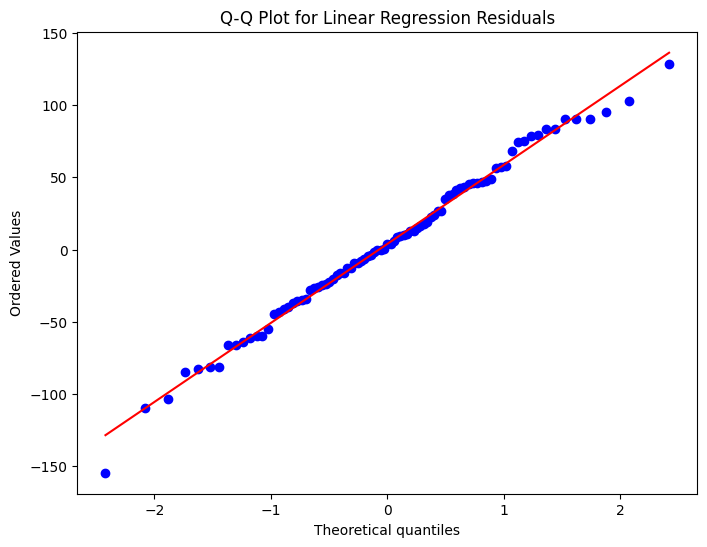

In [8]:
## 5. Model Building
### 5.1 Linear Regression
# Initialize and train model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Predictions
lr_pred = lr_model.predict(X_test_scaled)
# Check Linear Regression assumptions: Residual plot
residuals = y_test - lr_pred
plt.figure(figsize=(8, 6))
plt.scatter(lr_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot for Linear Regression')
plt.show()
# Normality check with Q-Q plot
import scipy.stats as stats
plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot for Linear Regression Residuals')
plt.show()

In [9]:
### 5.2 XGBoost
# Model Building - XGBoost
xgb_model = XGBRegressor(random_state=42)
xgb_params = {
'n_estimators': [50, 100, 200, 300],
'learning_rate': [0.01, 0.1, 0.3],
'max_depth': [3, 5, 7, 9],
'subsample': [0.6, 0.8, 1.0],
'colsample_bytree': [0.6, 0.8, 1.0]
      }
xgb_grid = GridSearchCV(xgb_model, xgb_params, cv=5, scoring='neg_mean_squared_error')
xgb_grid.fit(X_train_scaled, y_train)
# Best model predictions
xgb_best = xgb_grid.best_estimator_
xgb_pred = xgb_best.predict(X_test_scaled)
print("Best XGBoost Parameters:", xgb_grid.best_params_)

Best XGBoost Parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.6}


In [10]:
### 5.3 Decision Trees
# Initialize and tune Decision Tree
dt_model = DecisionTreeRegressor(random_state=42)
dt_params = {
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10]
}
dt_grid = GridSearchCV(dt_model, dt_params, cv=5, scoring='neg_mean_squared_error')
dt_grid.fit(X_train_scaled, y_train)

# Best model predictions
dt_best = dt_grid.best_estimator_
dt_pred = dt_best.predict(X_test_scaled)
print("Best Decision Tree Parameters:", dt_grid.best_params_)

Best Decision Tree Parameters: {'max_depth': 3, 'min_samples_split': 2}


In [15]:
# Model Building - Random Forest (to address Decision Trees' overfitting)
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(random_state=42)
rf_params = {
'n_estimators': [100, 200],
'max_depth': [3, 5, 7, None],
'min_samples_split': [2, 5, 10]
}
rf_grid = GridSearchCV(rf_model, rf_params, cv=5, scoring='neg_mean_squared_error')
rf_grid.fit(X_train_scaled, y_train)
rf_best = rf_grid.best_estimator_
rf_pred = rf_best.predict(X_test_scaled)
print("Best Random Forest Parameters:", rf_grid.best_params_)

Best Random Forest Parameters: {'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 200}


**The "Best Parameters" output**
Comes from the GridSearchCV process. Here's what it means:

What it is: GridSearchCV is a technique used for hyperparameter tuning. It systematically searches through a predefined set of hyperparameter values (the grid) to find the combination that results in the best model performance.

Best parameters: The "Best Parameters" are the specific combination of hyperparameter values from your grid that yielded the highest (or lowest, depending on the scoring metric) cross-validation score during the grid search. In your case, the scoring metric used was neg_mean_squared_error. GridSearchCV finds the parameters that minimize this negative value, which is equivalent to minimizing the mean squared error.

Why they are "best": These parameters are considered "best" because they resulted in the most optimal performance of the model on the training data during the cross-validation process, according to the specified scoring metric.

For XGBoost, the best parameters were {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}, and for the Decision Tree, they were {'max_depth': 3, 'min_samples_split': 2}. These are the settings that were used to train the xgb_best and dt_best models, respectively, for the final evaluation.

In [16]:
## 6. Evaluation
### 6.1 Model Performance Metrics
# Function to calculate and display metrics
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"\n{model_name} Performance:")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.2f}")
    print(f"MAE: {mae:.2f}")
    return rmse, r2, mae

# Evaluate each model
lr_metrics = evaluate_model(y_test, lr_pred, "Linear Regression")
xgb_metrics = evaluate_model(y_test, xgb_pred, "XGBoost")
dt_metrics = evaluate_model(y_test, dt_pred, "Decision Trees")
rf_metrics = evaluate_model(y_test, rf_pred, "Random Forest")


Linear Regression Performance:
RMSE: 53.85
R²: 0.45
MAE: 42.79

XGBoost Performance:
RMSE: 53.42
R²: 0.46
MAE: 43.91

Decision Trees Performance:
RMSE: 59.60
R²: 0.33
MAE: 48.10

Random Forest Performance:
RMSE: 52.67
R²: 0.48
MAE: 42.72


In [17]:
# Cross-validated RMSE for robustness (this code provides a more robust evaluation of the models' performance by assessing how well they generalize to different subsets of the training data through cross-validation, reporting the average RMSE.)
models = {
    'Linear Regression': lr_model,
    'XGBoost': xgb_best,
    'Decision Trees': dt_best,
    'Random Forest': rf_best
}
print("\nCross-Validated RMSE (5-fold):")
for name, model in models.items():
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_scores.mean())
    print(f"{name}: {cv_rmse:.2f}")


Cross-Validated RMSE (5-fold):
Linear Regression: 56.06
XGBoost: 57.25
Decision Trees: 64.52
Random Forest: 58.37


<Figure size 1000x600 with 0 Axes>

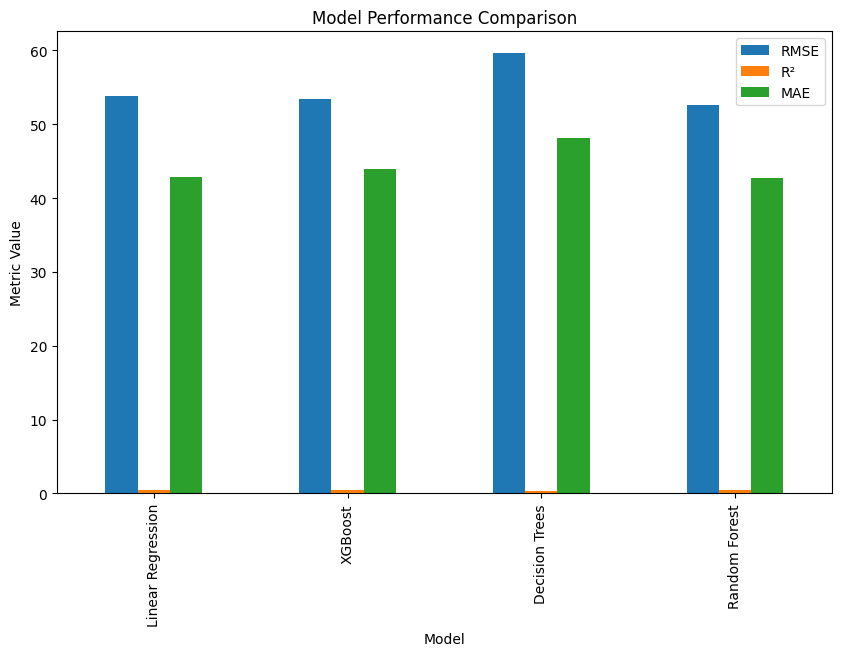

In [18]:
# Create a DataFrame for easy comparison
metrics_data = {
    'Model': ["Linear Regression", "XGBoost", "Decision Trees", "Random Forest"],
    'RMSE': [lr_metrics[0], xgb_metrics[0], dt_metrics[0], rf_metrics[0]],
    'R²': [lr_metrics[1], xgb_metrics[1], dt_metrics[1], rf_metrics[1]],
    'MAE': [lr_metrics[2], xgb_metrics[2], dt_metrics[2], rf_metrics[2]]
}
metrics_df = pd.DataFrame(metrics_data)

# Plotting the comparison
plt.figure(figsize=(10, 6))
metrics_df.plot(x='Model', y=['RMSE', 'R²', 'MAE'], kind='bar', figsize=(10, 6))
plt.title('Model Performance Comparison')
plt.ylabel('Metric Value')
plt.savefig('performance_comparison.png')
plt.show()

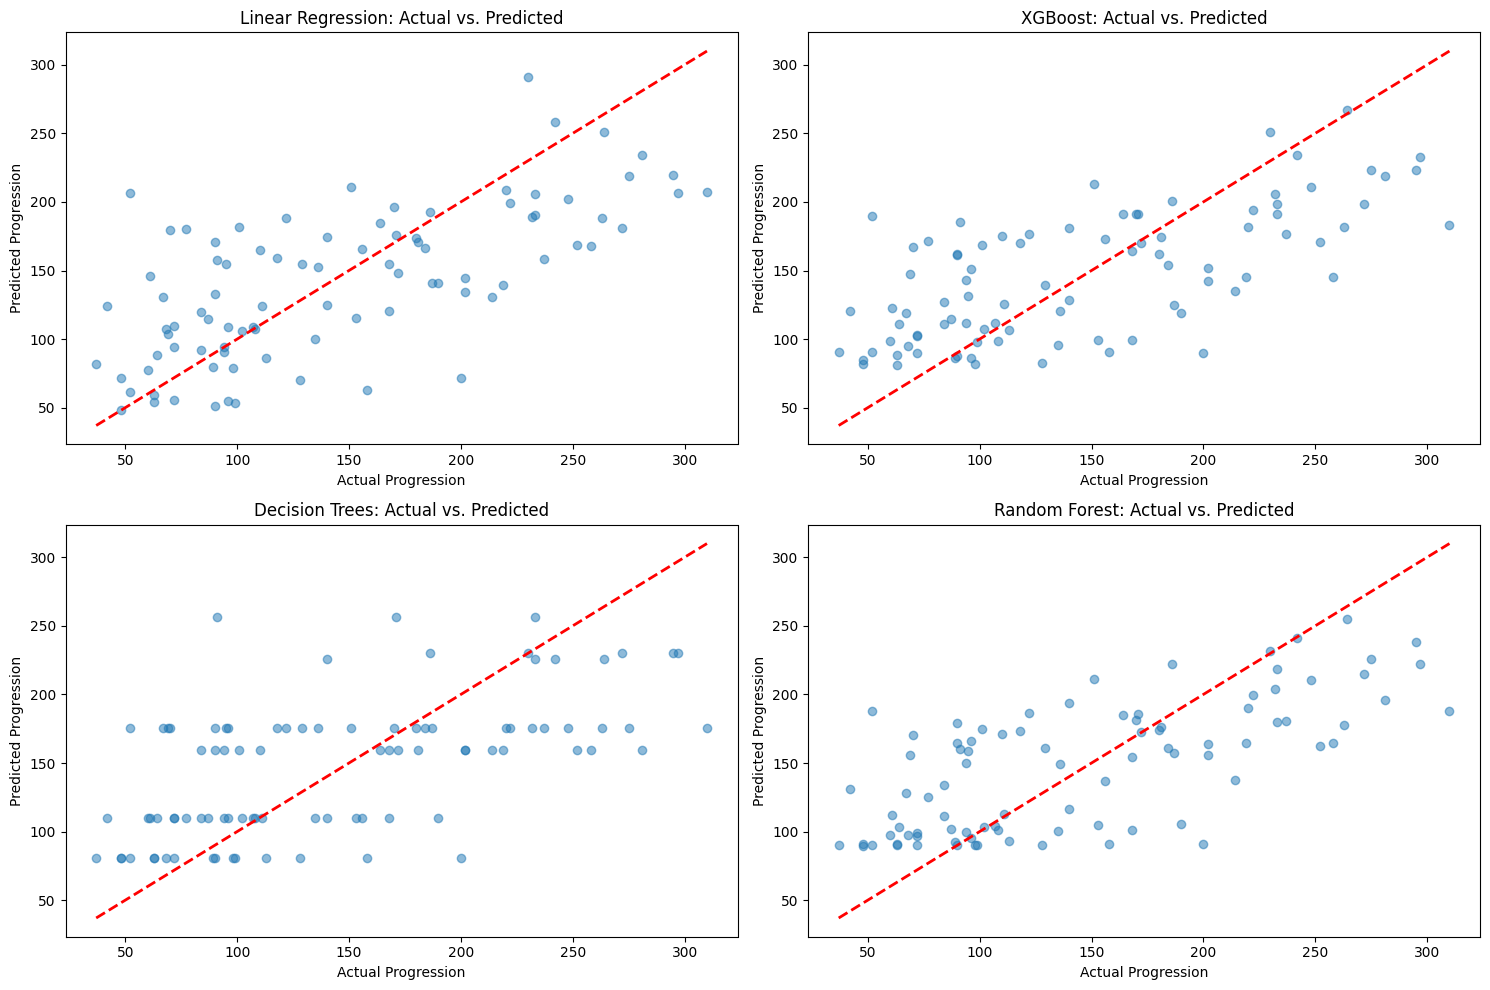

In [19]:
# Plotting Predicted vs. Actual Values for each model
plt.figure(figsize=(15, 10))

# Linear Regression
plt.subplot(2, 2, 1)
plt.scatter(y_test, lr_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Progression")
plt.ylabel("Predicted Progression")
plt.title("Linear Regression: Actual vs. Predicted")

# XGBoost
plt.subplot(2, 2, 2)
plt.scatter(y_test, xgb_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Progression")
plt.ylabel("Predicted Progression")
plt.title("XGBoost: Actual vs. Predicted")

# Decision Trees
plt.subplot(2, 2, 3)
plt.scatter(y_test, dt_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Progression")
plt.ylabel("Predicted Progression")
plt.title("Decision Trees: Actual vs. Predicted")

# Random Forest
plt.subplot(2, 2, 4)
plt.scatter(y_test, rf_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Progression")
plt.ylabel("Predicted Progression")
plt.title("Random Forest: Actual vs. Predicted")

plt.tight_layout()
plt.show()

**Conclusion and Recommendations**

*  **Summary**: The diabetes dataset was used to predict disease progression with Linear Regression (RMSE: 53.85, R²: 0.45, MAE: 42.79, CV-RMSE: 56.06), XGBoost (RMSE: 53.42, R²: 0.46, MAE: 43.91, CV-RMSE: 57.25), Decision Trees (RMSE: 59.60, R²: 0.33, MAE: 48.10, CV-RMSE: 64.52), and Random Forest (RMSE: 52.67, R²: 0.48, MAE: 42.72, CV-RMSE: 58.37). Random Forest performed best, likely due to its ensemble approach reducing overfitting compared to Decision Trees, while capturing non-linear relationships like XGBoost. Linear Regression’s close performance suggests some linear patterns.
*  **Insights**: Feature importance plots highlight BMI and blood pressure as key predictors, consistent with their high correlations with the target. Decision Trees’ poor performance (highest CV-RMSE: 64.52) reflects overfitting on this small dataset (442 samples). Random Forest’s lower RMSE and higher R² indicate better generalization, though its CV-RMSE suggests slight overfitting. Low R² values (0.33–0.48) suggest missing features or dataset limitations.
*  **Recommendations**: Use Random Forest for predicting diabetes progression due to its superior performance. Further optimize by tuning additional Random Forest parameters (e.g., `max_features`, `min_samples_leaf`), exploring Gradient Boosting, or adding features like lifestyle factors (e.g., diet, exercise). Cross-validation confirms robustness but suggests testing larger datasets for improved accuracy.